Preregistartion: https://osf.io/z9d4x

Data storage: https://osf.io/ayk28/files/osfstorage

Danila Valko

### setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
%%capture
!pip install semopy
import math, random
import scipy
import semopy as sem
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.multitest import multipletests
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import json
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
def bootstrap(data, n=10000, func=np.median, p=0.95, seed=13):
    random.seed(seed)
    np.random.seed(seed)
    sample_size = len(data)
    simulations = [func(np.random.choice(data, size=sample_size, replace=True)) for i in range(n)]
    simulations.sort()
    u_pval = (1+p)/2.
    l_pval = (1-u_pval)
    l_indx = int(np.floor(n*l_pval))
    u_indx = int(np.floor(n*u_pval))
    m = func(data)
    return (m, (simulations[u_indx] - simulations[l_indx]) / 2)

def cohen_r(p, n):
    # https://www.researchgate.net/publication/51554230_Effect_Size_Estimates_Current_Use_Calculations_and_Interpretation
    # Fritz, C. O., Morris, P. E., & Richler, J. J. (2012). Effect size estimates: Current use, calculations, and interpretation. Journal of Experimental Psychology: General, 141(1), 2–18. https://doi.org/10.1037/a0024338
    # the r proposed by Cohen (1988);Cohen’s guidelines for r are that 
    # a large effect is .5, a medium effect is .3, and a small effect is .1 
    # (Coolican, 2009, p. 395).
    # Cohen’s r (Fritz et al., 2012; Cohen 1988) for Wilcoxon test is reported.
    return abs(scipy.stats.norm.ppf(p/2)) / math.sqrt(n) 

def cohen_d(f):
    # https://www.researchgate.net/publication/51554230_Effect_Size_Estimates_Current_Use_Calculations_and_Interpretation
    # https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00863/full
    # Cohen’s d derived from F statistic (Fritz et al., 2012)
    eta_sq = (f.fvalue * f.df_num) / ((f.fvalue * f.df_num) + f.df_denom)
    d = 2 * math.sqrt(eta_sq) / math.sqrt(1 - eta_sq)
    return d

def spearmanCI(r, n):
  stderr = 1.0 / math.sqrt(n - 3)
  delta = 1.96 * stderr
  lower = math.tanh(math.atanh(r) - delta)
  upper = math.tanh(math.atanh(r) + delta)
  return lower, upper

def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
def make_xy(x, y):
  df = None
  for i in range(len(x)):
    d = pd.DataFrame(y[i])
    d['_group'] = x[i]
    df = pd.concat([df, d], ignore_index=True)
  return df.rename(columns={df.columns[0]:'y', '_group':'x'})

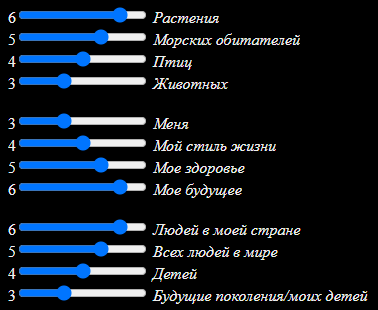

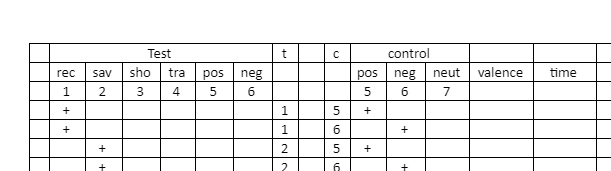


## Study1 (pilot)

In [5]:
data = pd.read_csv('/content/drive/MyDrive/pilot_data_v1.0.csv', sep=';')
print(len(data), int(len(data) / 32))
rec, sav, sho, tra, pos, neg, neut = 1, 2, 3, 4, 5, 6, 7
eco = [rec, sav, sho, tra]

5856 183


In [6]:
print(len(data.drop_duplicates(subset=['id'])[['age', 'gender', 'income', 'work', 'car']].dropna()))
data.drop_duplicates(subset=['id']).describe().T[17:23]

166


,count,mean,std,min,25%,50%,75%,max
age,179.0,23.726257,7.260632,14.0,20.0,21.0,25.00,55.0
gender,180.0,0.283333,0.451874,0.0,0.0,0.0,1.00,1.0
income,172.0,1.988372,1.333282,1.0,1.0,1.0,2.25,6.0
work,181.0,0.469613,0.500460,0.0,0.0,0.0,1.00,1.0
car,183.0,0.568306,0.496671,0.0,0.0,1.0,1.00,1.0
edu,182.0,2.714286,0.754884,1.0,3.0,3.0,3.00,4.0


In [7]:
data[['id', 'age', 'gender', 'income', 'work', 'car', 'edu']].dropna().drop_duplicates(subset=['id']).describe().T

,count,mean,std,min,25%,50%,75%,max
id,165.0,91.236364,52.722570,0.0,47.0,91.0,136.0,181.0
age,165.0,24.006061,7.343071,14.0,20.0,21.0,26.0,55.0
gender,165.0,0.290909,0.455564,0.0,0.0,0.0,1.0,1.0
income,165.0,1.987879,1.334294,1.0,1.0,1.0,2.0,6.0
work,165.0,0.490909,0.501439,0.0,0.0,0.0,1.0,1.0
car,165.0,0.551515,0.498853,0.0,0.0,1.0,1.0,1.0
edu,165.0,2.763636,0.714748,1.0,3.0,3.0,3.0,4.0


### AFP

In [8]:
d = data.copy()
invalid = d[d.time > 4000].id.unique()
d = d[d.id.apply(lambda x: not x in invalid)]
print(f'{len(invalid)} - dropout')
con = d[((d.test == neg) & (d.ctrl == neg)) |
        ((d.test == pos) & (d.ctrl == pos))].groupby(by=['id']).aggregate(np.mean) #congruent
inc = d[((d.test == neg) & (d.ctrl == pos)) |
        ((d.test == pos) & (d.ctrl == neg))].groupby(by=['id']).aggregate(np.mean) #incongruent
eco_pos = d[d.test.apply(lambda x: x in eco) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
eco_neg = d[d.test.apply(lambda x: x in eco) & (d.ctrl == neg)].groupby(by=['id']).aggregate(np.mean)
print(f'n={len(con)}, inc/con mean diff {inc.time.mean()-con.time.mean():.1f} ms, eco-neg/eco-pos mean diff {eco_neg.time.mean()-eco_pos.time.mean():.1f} ms')

69 - dropout
n=114, inc/con mean diff 67.9 ms, eco-neg/eco-pos mean diff 166.5 ms


In [9]:
# Normality tests
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
k, p = stats.normaltest(eco_pos.time)
print(f"p = {p:g} ~ {p:.3f}")
k, p = stats.normaltest(eco_neg.time)
print(f"p = {p:g} ~ {p:.3f}")
k, p = stats.normaltest(con.time)
print(f"p = {p:g} ~ {p:.3f}")
k, p = stats.normaltest(inc.time)
print(f"p = {p:g} ~ {p:.3f}")

p = 0.00231246 ~ 0.002
p = 7.87519e-05 ~ 0.000
p = 0.0890267 ~ 0.089
p = 1.85934e-05 ~ 0.000


In [10]:
print(f'AFP, response time analysis with the paired Wilcoxon signed-rank test')
t1, p1 = wilcoxon(con.time, inc.time)
t2, p2 = wilcoxon(con.time, inc.time, alternative='less')
r1 = cohen_r(p1, len(con.time))
r2 = cohen_r(p2, len(con.time))
m1 = bootstrap(con.time)
m2 = bootstrap(inc.time)
print(f'''
congruent vs incongruent
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-less: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
t1, p1 = wilcoxon(eco_pos.time, eco_neg.time)
t2, p2 = wilcoxon(eco_pos.time, eco_neg.time, alternative='less')
r1 = cohen_r(p1, len(eco_neg.time))
r2 = cohen_r(p2, len(eco_neg.time))
m1 = bootstrap(eco_pos.time)
m2 = bootstrap(eco_neg.time)
print(f'''
env.+positive vs env.+negative
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-less: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
t1, p1 = wilcoxon(eco_pos.time, con.time)
t2, p2 = wilcoxon(eco_pos.time, con.time, alternative='less')
r1 = cohen_r(p1, len(con.time))
r2 = cohen_r(p2, len(con.time))
m1 = bootstrap(eco_pos.time)
m2 = bootstrap(con.time)
print(f'''
env.+positive vs congruent
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-less: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
t1, p1 = wilcoxon(eco_pos.time, inc.time)
t2, p2 = wilcoxon(eco_pos.time, inc.time, alternative='less')
r1 = cohen_r(p1, len(inc.time))
r2 = cohen_r(p2, len(inc.time))
m1 = bootstrap(eco_pos.time)
m2 = bootstrap(inc.time)
print(f'''
env.+positive vs incongruent
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-less: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
t1, p1 = wilcoxon(eco_neg.time, con.time)
t2, p2 = wilcoxon(eco_neg.time, con.time, alternative='greater')
r1 = cohen_r(p1, len(con.time))
r2 = cohen_r(p2, len(con.time))
m1 = bootstrap(eco_neg.time)
m2 = bootstrap(con.time)
print(f'''
env.+negative vs congruent
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-greater: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
t1, p1 = wilcoxon(eco_neg.time, inc.time)
t2, p2 = wilcoxon(eco_neg.time, inc.time, alternative='less')
r1 = cohen_r(p1, len(inc.time))
r2 = cohen_r(p2, len(inc.time))
m1 = bootstrap(eco_neg.time)
m2 = bootstrap(inc.time)
print(f'''
env.+negative vs incongruent
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-less: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
print('Note. Null hypothesis H0: the median of the differences is located at zero.')
print('One-sided alternative (less) hypothesis H1: the median of the differences is located on the left μ < 0.')
print('One-sided alternative (greater) hypothesis H2: the median of the differences is located on the right μ > 0.')
print('† Bootstrapped 95% confidence intervals for the median from 10000 resamples are reported.')
print('‡ Cohen’s r (Fritz et al., 2012; Cohen, 1988) for Wilcoxon signed-rank test is reported.')
# a large effect is .5, a medium effect is .3, and a small effect is .1 (Coolican, 2009, p. 395).

AFP, response time analysis with the paired Wilcoxon signed-rank test

congruent vs incongruent
Mdn1=1510.1, 95%CI†[1439.1–1581.2],
Mdn2=1581.6, 95%CI†[1527.2–1636.0],
two-sided: W=2397.0, p=0.013, r‡=0.23,
alternative-less: W=2397.0, p=0.006, r‡=0.26


env.+positive vs env.+negative
Mdn1=1491.5, 95%CI†[1444.4–1538.6],
Mdn2=1631.0, 95%CI†[1550.9–1711.1],
two-sided: W=1233.0, p=0.000, r‡=0.54,
alternative-less: W=1233.0, p=0.000, r‡=0.55


env.+positive vs congruent
Mdn1=1491.5, 95%CI†[1444.4–1538.6],
Mdn2=1510.1, 95%CI†[1439.1–1581.2],
two-sided: W=2909.5, p=0.298, r‡=0.10,
alternative-less: W=2909.5, p=0.149, r‡=0.14


env.+positive vs incongruent
Mdn1=1491.5, 95%CI†[1444.4–1538.6],
Mdn2=1581.6, 95%CI†[1527.2–1636.0],
two-sided: W=2085.0, p=0.001, r‡=0.32,
alternative-less: W=2085.0, p=0.000, r‡=0.33


env.+negative vs congruent
Mdn1=1631.0, 95%CI†[1550.9–1711.1],
Mdn2=1510.1, 95%CI†[1439.1–1581.2],
two-sided: W=1578.5, p=0.000, r‡=0.45,
alternative-greater: W=4976.5, p=0.000, r‡=0.46

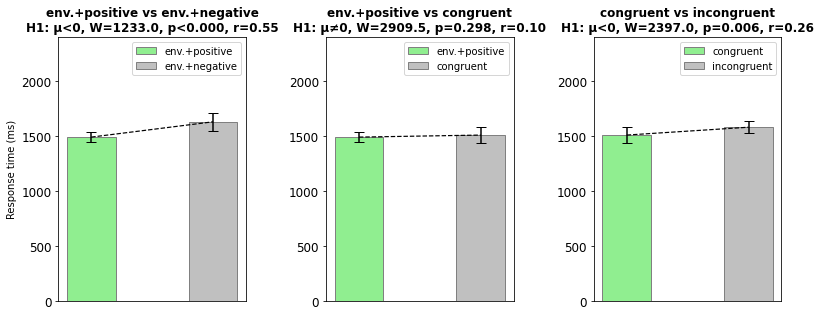

In [11]:
d = [[eco_pos.time, eco_neg.time],
     [eco_pos.time, con.time],
#    [eco_neg.time, inc.time],
     [con.time, inc.time]]
w = wilcoxon(d[0][0], d[0][1], alternative='less',)
r = cohen_r(w[1], len(d[0][0]))
t = [f'env.+positive vs env.+negative\nH1: μ<0, W={w[0]}, p<{w[1]:.3f}, r={r:.2f}']
w = wilcoxon(d[1][0], d[1][1], alternative='two-sided')
r = cohen_r(w[1], len(d[1][0]))
t += [f'env.+positive vs congruent\nH1: μ≠0, W={w[0]}, p={w[1]:.3f}, r={r:.2f}']
w = wilcoxon(d[2][0], d[2][1], alternative='less')
r = cohen_r(w[1], len(d[2][0]))
t += [f'congruent vs incongruent\nH1: μ<0, W={w[0]}, p={w[1]:.3f}, r={r:.2f}']

l=[['env.+positive', 'env.+negative'],
   ['env.+positive', 'congruent'],
#  ['env.+negative', 'incongruent'],
   ['congruent', 'incongruent']]

barWidth = 0.2
fig, axs = plt.subplots(1, len(d), figsize=(11.5, 4.5))
for i, ax in enumerate(axs.flat):
    m1 = bootstrap(d[i][0])
    m2 = bootstrap(d[i][1])
    ax.bar(0.0, m1[0], width = barWidth, color = 'lightgreen', edgecolor = 'gray', capsize=5, label=l[i][0], yerr=m1[1])
    ax.bar(0.5, m2[0], width = barWidth, color = 'silver', edgecolor = 'gray', capsize=5, label=l[i][1], yerr=m2[1])
    ax.plot((0.0, 0.5), (m1[0], m2[0]), 'k--', linewidth = 1.2)
    if i > 0:
      pass
    else:
      ax.set_ylabel('Response time (ms)')
    ax.set_xticklabels([])
    ax.legend()
    ax.set_xticks([])
    ax.set_title(t[i], fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelsize=12)
    ax.set_ylim([0, 2400])
plt.tight_layout()

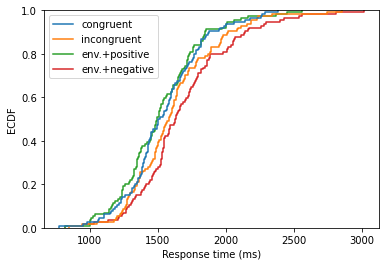

In [12]:
def plot_ecdf(data, label=''):
    fig = plt.figure()
    ax = fig.add_subplot()
    sns.ecdfplot(data = data, legend = data)
    plt.xlabel(label)
    plt.ylabel("ECDF")
    plt.show()

_d = {'congruent': con.time,
      'incongruent': inc.time,
      'env.+positive': eco_pos.time,
      'env.+negative': eco_neg.time}

plot_ecdf(_d, 'Response time (ms)')

#### Contrast analysis

For the AFP, participants will be quicker to respond when the primes are positive or associated with the environment and the target is also positive rather than negative. This can be reflected in contrast codes (-1,-1,2) X (-1, 1) vs. (-1,1,0) X (-1,1). Then, the authors could look at the simple effects by looking at the effect of the prime when the targets are positive (-1,-1, 2) X (1, 0), and when the targets are negative (-1, -1, 2) X (0, 1).

In [13]:
# https://personal.utdallas.edu/~herve/abdi-contrasts2010-pretty.pdf
# https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.t_test.html
# https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.f_test.html
d = data.copy()
invalid = d[d.time > 4000].id.unique()
d = d[d.id.apply(lambda x: not x in invalid)]
print(f'{len(invalid)} - dropout')
d['p_env'] = d['test'].apply(lambda x: x in eco)
d['p_pos'] = d['test'] == pos
d['p_neg'] = d['test'] == neg
d['t_pos'] = d['ctrl'] == pos
d['t_neg'] = d['ctrl'] == neg
d['t_neut'] = d['ctrl'] == neut
d = d.groupby(by=['id', 'p_env', 'p_pos', 'p_neg', 't_pos', 't_neg', 't_neut'])\
          .aggregate(np.mean).reset_index()
d = d[d['t_neut'] == False][['id', 'p_env', 'p_pos', 'p_neg', 't_pos', 't_neg', 'time']]

f = 'time ~ p_env + p_pos + p_neg + t_pos + t_neg'
# use robust linear regression https://www.statsmodels.org/stable/rlm.html
m = smf.rlm(f, d, M=sm.robust.norms.HuberT()).fit()
f_test = m.f_test([[0, 1, 1, -2, 1, -1], 
                   [0, 1, -1, 0, 1, -1]])
print(f_test)
print(f'Cohen’s d* = {cohen_d(f_test)}')
print('* Cohen’s d derived from F statistic (Fritz et al., 2012)')

69 - dropout
<F test: F=array([[4.33178689]]), p=0.01350865921162594, df_denom=680, df_num=2>
Cohen’s d* = 0.22574808670150187
* Cohen’s d derived from F statistic (Fritz et al., 2012)


In [14]:
m.t_test([[0, 1, 1, -2, 1, -1],
          [0, 1, -1, 0, 1, -1],
          [0, 1, 1, -2, 1, 0],
          [0, 1, 1, -2, 0, 1]])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0          -139.3363     59.270     -2.351      0.019    -255.503     -23.170
c1           -93.4854     39.960     -2.339      0.019    -171.805     -15.166
c2           353.6095     55.188      6.407      0.000     245.443     461.776
c3           486.9039     55.188      8.823      0.000     378.737     595.071

In [15]:
m.f_test([0, 1, 1, -2, 1, -1])

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[5.52666604]]), p=0.01901337400107113, df_denom=680, df_num=1>

In [16]:
m.f_test([0, 1, -1, 0, 1, -1])

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[5.47325194]]), p=0.019598162834424348, df_denom=680, df_num=1>

In [17]:
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
# http://jpktd.blogspot.com/2013/04/multiple-testing-p-value-corrections-in.html

# holm - step-down method that applies the Bonferroni correction (or Holm–Bonferroni method, see [Holm, 1979])
# hommel - controls the FWER and it is valid under independence and under positive dependence of the p-value, see [Hommel, 1988]
# fdr_tsbh - controls the FDR under independence and is robust to some form of positive dependence of the p-values, see [Benjamini & Hochberg, 1995]
# fdr_by - controls the FDR also for other forms of dependence including the case when the p-values are negatively correlated, see [Benjamini & Yekutiely, 2001]
print(multipletests([0.019, 0.019], alpha=0.05, method='holm', is_sorted=False, returnsorted=False)[:2])
print(multipletests([0.019, 0.019], alpha=0.05, method='hommel', is_sorted=False, returnsorted=False)[:2])
print(multipletests([0.019, 0.019], alpha=0.05, method='fdr_tsbh', is_sorted=False, returnsorted=False)[:2])
print(multipletests([0.019, 0.019], alpha=0.05, method='fdr_by', is_sorted=False, returnsorted=False)[:2])

(array([ True,  True]), array([0.038, 0.038]))
(array([ True,  True]), array([0.019, 0.019]))
(array([ True,  True]), array([0.019, 0.019]))
(array([ True,  True]), array([0.0285, 0.0285]))


### AMP

In [18]:
d = data.copy()
a = d[(d.test == neg) & (d.ctrl == neg) & (d.valence > 3)].id.unique()
b = d[(d.test == pos) & (d.ctrl == pos) & (d.valence < 3)].id.unique()
invalid = {*a, *b}
print(f'{len(invalid)} - dropout')
d = d[d.id.apply(lambda x: not x in invalid)]
pos_neut = d[(d.test == pos) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #positive-neutral
neg_neut = d[(d.test == neg) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #negative-neutral
eco_neut = d[d.test.apply(lambda x: x in eco) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #eco-neutral
rec_neut = d[(d.test == rec) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sav_neut = d[(d.test == sav) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sho_neut = d[(d.test == sho) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
tra_neut = d[(d.test == tra) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
print(f'n={len(pos_neut)}')
print(f'eco valence median: {eco_neut.valence.median()}')
print(f'pos vs neg mean diff {pos_neut.valence.mean()-neg_neut.valence.mean():.2f} pts')
print(f'eco vs neg mean diff {eco_neut.valence.mean()-neg_neut.valence.mean():.2f} pts') 
print(f'eco vs pos mean diff {eco_neut.valence.mean()-pos_neut.valence.mean():.2f} pts')

43 - dropout
n=140
eco valence median: 3.125
pos vs neg mean diff 0.38 pts
eco vs neg mean diff 0.29 pts
eco vs pos mean diff -0.09 pts


In [19]:
# Normality tests
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
k, p = stats.normaltest(eco_neut.valence)
print(f"p = {p:g} ~ {p:.3f}")
k, p = stats.normaltest(pos_neut.valence)
print(f"p = {p:g} ~ {p:.3f}")
k, p = stats.normaltest(neg_neut.valence)
print(f"p = {p:g} ~ {p:.3f}")

p = 0.922197 ~ 0.922
p = 0.440298 ~ 0.440
p = 0.149909 ~ 0.150


In [20]:
cor_p = pearsonr(eco_neut.valence, eco_neut.time)
cor_s = spearmanr(eco_neut.valence, eco_neut.time)
ci = spearmanCI(cor_s[0], len(eco_neut.valence))
print(f'Correlation between valence and responce time (env.):')
print(f'Pearson r({len(eco_neut.valence)-2})={cor_p[0]:.2f} p={cor_p[1]:.3f}')
print(f'Spearman r({len(eco_neut.valence)-2})={cor_s[0]:.2f}, 95%CI [{ci[0]:.2f}–{ci[1]:.2f}], p={cor_s[1]:.3f}')

cor_p = pearsonr(pos_neut.valence, pos_neut.time)
cor_s = spearmanr(pos_neut.valence, pos_neut.time)
ci = spearmanCI(cor_s[0], len(pos_neut.valence))
print(f'Correlation between valence and responce time (pos):')
print(f'Pearson r({len(pos_neut.valence)-2})={cor_p[0]:.2f} p={cor_p[1]:.3f}')
print(f'Spearman r({len(pos_neut.valence)-2})={cor_s[0]:.2f}, 95%CI [{ci[0]:.2f}–{ci[1]:.2f}], p={cor_s[1]:.3f}')

cor_p = pearsonr(neg_neut.valence, neg_neut.time)
cor_s = spearmanr(neg_neut.valence, neg_neut.time)
ci = spearmanCI(cor_s[0], len(neg_neut.valence))
print(f'Correlation between valence and responce time (neg):')
print(f'Pearson r({len(neg_neut.valence)-2})={cor_p[0]:.2f} p={cor_p[1]:.3f}')
print(f'Spearman r({len(neg_neut.valence)-2})={cor_s[0]:.2f}, 95%CI [{ci[0]:.2f}–{ci[1]:.2f}], p={cor_s[1]:.3f}')

Correlation between valence and responce time (env.):
Pearson r(138)=0.08 p=0.337
Spearman r(138)=0.05, 95%CI [-0.12–0.21], p=0.555
Correlation between valence and responce time (pos):
Pearson r(138)=-0.05 p=0.582
Spearman r(138)=-0.05, 95%CI [-0.22–0.12], p=0.549
Correlation between valence and responce time (neg):
Pearson r(138)=0.15 p=0.081
Spearman r(138)=0.14, 95%CI [-0.03–0.30], p=0.104


In [21]:
print(f'AMP, affective valence analysis with the paired Wilcoxon signed-rank test')
t1, p1 = wilcoxon(pos_neut.valence, neg_neut.valence)
t2, p2 = wilcoxon(pos_neut.valence, neg_neut.valence, alternative='greater')
r1 = cohen_r(p1, len(pos_neut.valence))
r2 = cohen_r(p2, len(pos_neut.valence))
m1 = bootstrap(pos_neut.valence)
m2 = bootstrap(neg_neut.valence)
print(f'''
positive vs negative
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-greater: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
t1, p1 = wilcoxon(eco_neut.valence, pos_neut.valence)
t2, p2 = wilcoxon(eco_neut.valence, pos_neut.valence, alternative='less')
r1 = cohen_r(p1, len(eco_neut.valence))
r2 = cohen_r(p2, len(eco_neut.valence))
m1 = bootstrap(eco_neut.valence)
m2 = bootstrap(pos_neut.valence)
print(f'''
env. vs positive
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-less: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
t1, p1 = wilcoxon(eco_neut.valence, neg_neut.valence)
t2, p2 = wilcoxon(eco_neut.valence, neg_neut.valence, alternative='greater')
r1 = cohen_r(p1, len(eco_neut.valence))
r2 = cohen_r(p2, len(eco_neut.valence))
m1 = bootstrap(eco_neut.valence)
m2 = bootstrap(neg_neut.valence)
print(f'''
env. vs negative
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-greater: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
print('Note. Null hypothesis H0: the median of the differences is located at zero, μ = 0.')
print('One-sided alternative (less) hypothesis H1: the median of the differences is located on the left, μ < 0.')
print('One-sided alternative (greater) hypothesis H2: the median of the differences is located on the right, μ > 0.')
print('† Bootstrapped 95% confidence intervals for the median from 10000 resamples are reported.')
print('‡ Cohen’s r (Fritz et al., 2012; Cohen, 1988) for Wilcoxon signed-rank test is reported.')

AMP, affective valence analysis with the paired Wilcoxon signed-rank test

positive vs negative
Mdn1=3.2, 95%CI†[3.0–3.5],
Mdn2=2.8, 95%CI†[2.6–2.9],
two-sided: W=2389.0, p=0.000, r‡=0.31,
alternative-greater: W=5361.0, p=0.000, r‡=0.33


env. vs positive
Mdn1=3.1, 95%CI†[3.0–3.2],
Mdn2=3.2, 95%CI†[3.0–3.5],
two-sided: W=3780.5, p=0.267, r‡=0.09,
alternative-less: W=3780.5, p=0.133, r‡=0.13


env. vs negative
Mdn1=3.1, 95%CI†[3.0–3.2],
Mdn2=2.8, 95%CI†[2.6–2.9],
two-sided: W=2788.0, p=0.000, r‡=0.31,
alternative-greater: W=5990.0, p=0.000, r‡=0.32

Note. Null hypothesis H0: the median of the differences is located at zero, μ = 0.
One-sided alternative (less) hypothesis H1: the median of the differences is located on the left, μ < 0.
One-sided alternative (greater) hypothesis H2: the median of the differences is located on the right, μ > 0.
† Bootstrapped 95% confidence intervals for the median from 10000 resamples are reported.
‡ Cohen’s r (Fritz et al., 2012; Cohen, 1988) for Wilcoxon

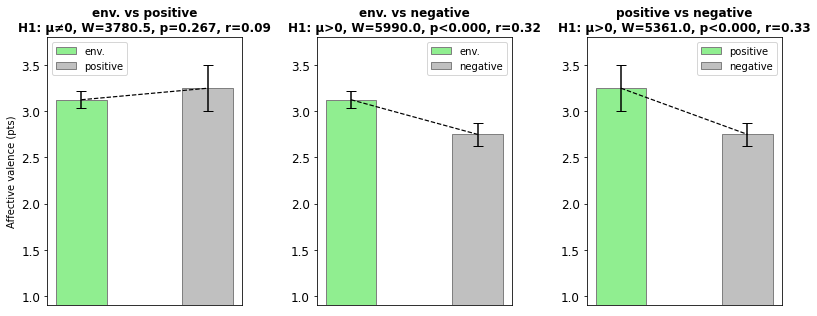

In [22]:
d = [[eco_neut.valence, pos_neut.valence],
     [eco_neut.valence, neg_neut.valence],
     [pos_neut.valence, neg_neut.valence]]

w = wilcoxon(d[0][0], d[0][1], alternative='two-sided',)
r = cohen_r(w[1], len(d[0][0]))
t = [f'env. vs positive\nH1: μ≠0, W={w[0]}, p={w[1]:.3f}, r={r:.2f}']
w = wilcoxon(d[1][0], d[1][1], alternative='greater')
r = cohen_r(w[1], len(d[1][0]))
t += [f'env. vs negative\nH1: μ>0, W={w[0]}, p<{w[1]:.3f}, r={r:.2f}']
w = wilcoxon(d[2][0], d[2][1], alternative='greater')
r = cohen_r(w[1], len(d[2][0]))
t += [f'positive vs negative\nH1: μ>0, W={w[0]}, p<{w[1]:.3f}, r={r:.2f}']

l=[['env.', 'positive'],
   ['env.', 'negative'],
   ['positive', 'negative']]

barWidth = 0.2
fig, axs = plt.subplots(1, len(d), figsize=(11.5, 4.5))
for i, ax in enumerate(axs.flat):
    m1 = bootstrap(d[i][0])
    m2 = bootstrap(d[i][1])
    ax.bar(0.0, m1[0], width = barWidth, color = 'lightgreen', edgecolor = 'gray', capsize=5, label=l[i][0], yerr=m1[1])
    ax.bar(0.5, m2[0], width = barWidth, color = 'silver', edgecolor = 'gray', capsize=5, label=l[i][1], yerr=m2[1])
    ax.plot((0.0, 0.5), (m1[0], m2[0]), 'k--', linewidth = 1.2)
    if i > 0:
      pass
    else:
      ax.set_ylabel('Affective valence (pts)')
    ax.set_xticklabels([])
    ax.legend()
    ax.set_xticks([])
    ax.set_title(t[i], fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelsize=12)
    ax.set_ylim([0.9, 3.8])
plt.tight_layout()

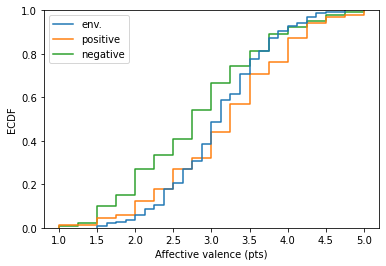

In [23]:
def plot_ecdf(data, label=''):
    fig = plt.figure()
    ax = fig.add_subplot()
    sns.ecdfplot(data = data, legend = data)
    plt.xlabel(label)
    plt.ylabel("ECDF")
    plt.show()

_d = {'env.': eco_neut.valence,
      'positive': pos_neut.valence,
      'negative': neg_neut.valence}

plot_ecdf(_d, 'Affective valence (pts)')

15 - dropout
58 - total dropout
n=125
                      Value
DoF            1.520000e+02
DoF Baseline   1.770000e+02
chi2           2.499517e+02
chi2 p-value   9.490730e-07
chi2 Baseline  9.952812e+02
CFI            8.802958e-01
GFI            7.488632e-01
AGFI           7.075578e-01
NFI            7.488632e-01
TLI            8.606076e-01
RMSEA          7.208973e-02
AIC            7.198505e+01
BIC            1.794610e+02
LogLik         2.007473e+00


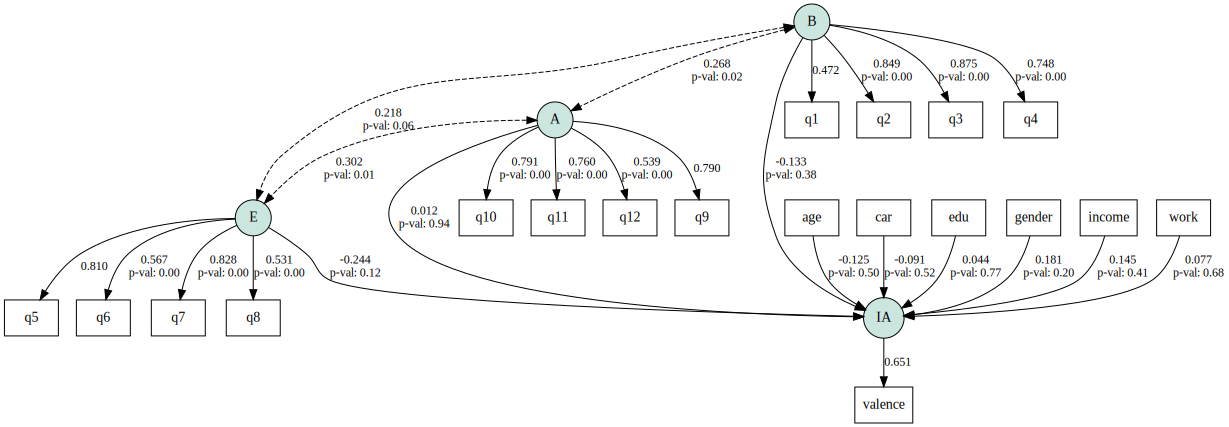

In [24]:
d = data.copy()
a = d[(d.test == neg) & (d.ctrl == neg) & (d.valence > 3)].id.unique()
b = d[(d.test == pos) & (d.ctrl == pos) & (d.valence < 3)].id.unique()
c = d[(d.q1 == 6) & (d.q2 == 5) & (d.q3 == 4) & (d.q4 == 3) & \
      (d.q5 == 3) & (d.q6 == 4) & (d.q7 == 5) & (d.q8 == 6) & \
      (d.q9 == 6) & (d.q10 == 5) & (d.q11 == 4) & (d.q12 == 3)].id.unique()
invalid = {*a, *b, *c}
print(f'{len([i for i in c if i not in {*a, *b}])} - dropout')
print(f'{len(invalid)} - total dropout')
d = d[d.id.apply(lambda x: not x in invalid)]#.dropna() #6 uncomplete
rec_v = d[(d.test == rec) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sav_v = d[(d.test == sav) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sho_v = d[(d.test == sho) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
tra_v = d[(d.test == tra) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
eco_v = d[d.test.apply(lambda x: x in eco) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #eco-neutral
print(f'n={len(eco_v)}')

random.seed(13)
np.random.seed(13)
#https://arxiv.org/pdf/2106.01140.pdf
d = eco_v.copy()
d.time = np.log(d.time)
d.age = np.log(d.age)
formula = """
B =~ q1 + q2 + q3 + q4
E =~ q5 + q6 + q7 + q8
A =~ q9 + q10 + q11 + q12
IA =~ valence
IA ~ B + E + A + gender + age + edu + car + income + work 
"""
model = sem.Model(formula)
model.fit(d, obj="MLW", solver="SLSQP") #MLW ULS GLS FIML DWLS WLS
sem.bias_correction(model, n=1000, resample_mean=True)
print(sem.calc_stats(model).T)
sem.semplot(model, "fig.pdf", plot_covs=True, std_ests=True, show=True)

15 - dropout
58 - total dropout
n=125
                      Value
DoF            5.900000e+01
DoF Baseline   7.800000e+01
chi2           1.599049e+02
chi2 p-value   3.029366e-11
chi2 Baseline  7.343521e+02
CFI            8.462640e-01
GFI            7.822503e-01
AGFI           7.121276e-01
NFI            7.822503e-01
TLI            7.967558e-01
RMSEA          1.174409e-01
AIC            6.142763e+01
BIC            1.519337e+02
LogLik         1.286185e+00


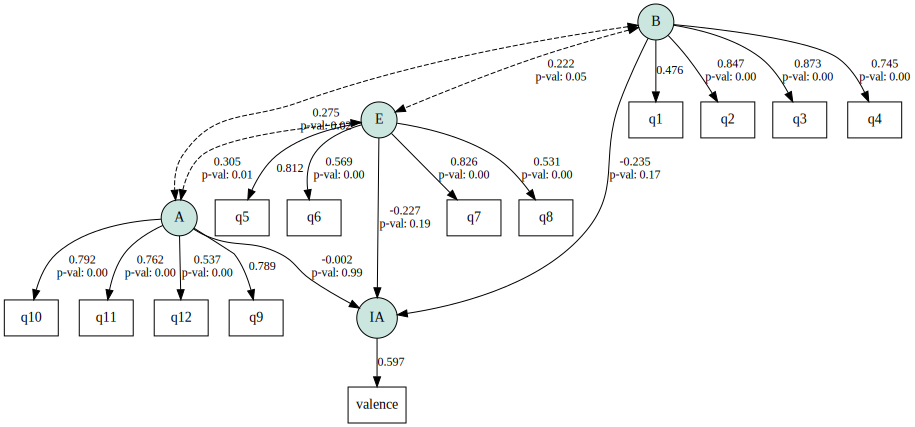

In [25]:
d = data.copy()
a = d[(d.test == neg) & (d.ctrl == neg) & (d.valence > 3)].id.unique()
b = d[(d.test == pos) & (d.ctrl == pos) & (d.valence < 3)].id.unique()
c = d[(d.q1 == 6) & (d.q2 == 5) & (d.q3 == 4) & (d.q4 == 3) & \
      (d.q5 == 3) & (d.q6 == 4) & (d.q7 == 5) & (d.q8 == 6) & \
      (d.q9 == 6) & (d.q10 == 5) & (d.q11 == 4) & (d.q12 == 3)].id.unique()
invalid = {*a, *b, *c}
print(f'{len([i for i in c if i not in {*a, *b}])} - dropout')
print(f'{len(invalid)} - total dropout')
d = d[d.id.apply(lambda x: not x in invalid)]#.dropna() #6 uncomplete
rec_v = d[(d.test == rec) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sav_v = d[(d.test == sav) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sho_v = d[(d.test == sho) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
tra_v = d[(d.test == tra) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
eco_v = d[d.test.apply(lambda x: x in eco) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #eco-neutral
print(f'n={len(eco_v)}')

random.seed(13)
np.random.seed(13)
#https://arxiv.org/pdf/2106.01140.pdf
d = eco_v.copy()
d.time = np.log(d.time)
d.age = np.log(d.age)
formula = """
B =~ q1 + q2 + q3 + q4
E =~ q5 + q6 + q7 + q8
A =~ q9 + q10 + q11 + q12
IA =~ valence
IA ~ B + E + A
"""
model = sem.Model(formula)
model.fit(d, obj="MLW", solver="SLSQP") #MLW ULS GLS FIML DWLS WLS
sem.bias_correction(model, n=1000, resample_mean=True)
print(sem.calc_stats(model).T)
sem.semplot(model, "fig.pdf", plot_covs=True, std_ests=True, show=True)

#### Contrast analysis

For the AMP, participants will have more positive evaluations of the target after exposure to positive or pro-environmental stimuli than after exposure to negative stimuli. This can be tested with contrast analyses. In concrete terms, this amounts to giving a weight to each condition, which here translates into the contrast codes (-1,-1,2) and (-1,1,0). The advantage here would be to present only one statistical test per study for each task, and thus gain statistical power. 

In [26]:
# https://personal.utdallas.edu/~herve/abdi-contrasts2010-pretty.pdf
# https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.t_test.html
d = data.copy()
a = d[(d.test == neg) & (d.ctrl == neg) & (d.valence > 3)].id.unique()
b = d[(d.test == pos) & (d.ctrl == pos) & (d.valence < 3)].id.unique()
invalid = {*a, *b}
d = d[d.id.apply(lambda x: not x in invalid)]
print(f'{len(invalid)} - dropout')
d['p_env'] = d['test'].apply(lambda x: x in eco)
d['p_pos'] = d['test'] == pos
d['p_neg'] = d['test'] == neg
d['t_pos'] = d['ctrl'] == pos
d['t_neg'] = d['ctrl'] == neg
d['t_neut'] = d['ctrl'] == neut
d = d.groupby(by=['id', 'p_env', 'p_pos', 'p_neg', 't_pos', 't_neg', 't_neut'])\
          .aggregate(np.mean).reset_index()
d = d[d['t_neut'] == True][['id', 'p_env', 'p_pos', 'p_neg', 'valence']]

#m = smf.ols(f, d).fit()
f = 'valence ~ p_env + p_pos + p_neg'
# use robust linear regression https://www.statsmodels.org/stable/rlm.html
m = smf.rlm(f, d, M=sm.robust.norms.HuberT()).fit()
f_test = m.f_test([[0, 1, 1, -2], 
                   [0, 1, -1, 0]])
print(f_test)
print(f'Cohen’s d* = {cohen_d(f_test)}')
print('* Cohen’s d derived from F statistic (Fritz et al., 2012)')

43 - dropout
<F test: F=array([[10.68530324]]), p=2.9814675637404594e-05, df_denom=417, df_num=2>
Cohen’s d* = 0.45276244014519784
* Cohen’s d derived from F statistic (Fritz et al., 2012)


In [27]:
m.t_test([[0, 1, 1, -2], 
          [0, 1, -1, 0]])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.7515      0.168      4.471      0.000       0.422       1.081
c1            -0.1142      0.097     -1.177      0.239      -0.304       0.076

In [28]:
m.f_test([0, 1, 1, -2])

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[19.98642781]]), p=1.0065583694063421e-05, df_denom=417, df_num=1>

In [29]:
m.f_test([[0, 1, -1, 0]])

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[1.38417867]]), p=0.24006181100941712, df_denom=417, df_num=1>

## Study2

In [30]:
data = pd.read_csv('/content/drive/MyDrive/final_data_v1.0.csv', sep=';')
print(len(data), int(len(data) / 32))
rec, sav, sho, tra, pos, neg, neut = 1, 2, 3, 4, 5, 6, 7
eco = [rec, sav, sho, tra]

6752 211


In [31]:
print(len(data.drop_duplicates(subset=['id'])[['age', 'gender', 'income', 'work', 'car']].dropna()))
data.drop_duplicates(subset=['id']).describe().T[17:23]

209


,count,mean,std,min,25%,50%,75%,max
age,209.0,24.516746,8.127645,12.0,19.0,22.0,26.0,61.0
gender,210.0,0.266667,0.443273,0.0,0.0,0.0,1.0,1.0
income,210.0,2.366667,1.418886,1.0,1.0,2.0,3.0,6.0
work,210.0,0.638095,0.481700,0.0,0.0,1.0,1.0,1.0
car,210.0,0.557143,0.497911,0.0,0.0,1.0,1.0,1.0
edu,210.0,2.542857,0.864267,1.0,2.0,3.0,3.0,4.0


In [32]:
data[['id', 'age', 'gender', 'income', 'work', 'car', 'edu']].dropna().drop_duplicates(subset=['id']).describe().T

,count,mean,std,min,25%,50%,75%,max
id,209.0,104.181818,60.766146,0.0,52.0,104.0,156.0,210.0
age,209.0,24.516746,8.127645,12.0,19.0,22.0,26.0,61.0
gender,209.0,0.267943,0.443951,0.0,0.0,0.0,1.0,1.0
income,209.0,2.373206,1.419117,1.0,1.0,2.0,3.0,6.0
work,209.0,0.636364,0.482201,0.0,0.0,1.0,1.0,1.0
car,209.0,0.559809,0.497602,0.0,0.0,1.0,1.0,1.0
edu,209.0,2.545455,0.865521,1.0,2.0,3.0,3.0,4.0


### AFP

In [33]:
d = data.copy()
invalid = d[d.time > 4000].id.unique()
d = d[d.id.apply(lambda x: not x in invalid)]
print(f'{len(invalid)} - dropout')
con = d[((d.test == neg) & (d.ctrl == neg)) |
        ((d.test == pos) & (d.ctrl == pos))].groupby(by=['id']).aggregate(np.mean) #congruent
inc = d[((d.test == neg) & (d.ctrl == pos)) |
        ((d.test == pos) & (d.ctrl == neg))].groupby(by=['id']).aggregate(np.mean) #incongruent
eco_pos = d[d.test.apply(lambda x: x in eco) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
eco_neg = d[d.test.apply(lambda x: x in eco) & (d.ctrl == neg)].groupby(by=['id']).aggregate(np.mean)
rec_pos = d[(d.test == rec) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
sav_pos = d[(d.test == sav) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
sho_pos = d[(d.test == sho) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
tra_pos = d[(d.test == tra) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
print(f'n={len(con)}, inc/con mean diff {inc.time.mean()-con.time.mean():.1f} ms, eco-neg/eco-pos mean diff {eco_neg.time.mean()-eco_pos.time.mean():.1f} ms')

71 - dropout
n=140, inc/con mean diff 51.6 ms, eco-neg/eco-pos mean diff 180.0 ms


In [34]:
# Normality tests
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
k, p = stats.normaltest(eco_pos.time)
print(f"p = {p:g} ~ {p:.3f}")
k, p = stats.normaltest(eco_neg.time)
print(f"p = {p:g} ~ {p:.3f}")
k, p = stats.normaltest(con.time)
print(f"p = {p:g} ~ {p:.3f}")
k, p = stats.normaltest(inc.time)
print(f"p = {p:g} ~ {p:.3f}")

p = 0.000482309 ~ 0.000
p = 0.000542425 ~ 0.001
p = 0.072706 ~ 0.073
p = 0.0392718 ~ 0.039


In [35]:
print(f'AFP, response time analysis with the paired Wilcoxon signed-rank test')
t1, p1 = wilcoxon(con.time, inc.time)
t2, p2 = wilcoxon(con.time, inc.time, alternative='less')
r1 = cohen_r(p1, len(con.time))
r2 = cohen_r(p2, len(con.time))
m1 = bootstrap(con.time)
m2 = bootstrap(inc.time)
print(f'''
congruent vs incongruent
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-less: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
t1, p1 = wilcoxon(eco_pos.time, eco_neg.time)
t2, p2 = wilcoxon(eco_pos.time, eco_neg.time, alternative='less')
r1 = cohen_r(p1, len(eco_pos.time))
r2 = cohen_r(p2, len(eco_pos.time))
m1 = bootstrap(eco_pos.time)
m2 = bootstrap(eco_neg.time)
print(f'''
env.+positive vs env.+negative
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-less: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
t1, p1 = wilcoxon(eco_pos.time, con.time)
t2, p2 = wilcoxon(eco_pos.time, con.time, alternative='less')
r1 = cohen_r(p1, len(con.time))
r2 = cohen_r(p2, len(con.time))
m1 = bootstrap(eco_pos.time)
m2 = bootstrap(con.time)
print(f'''
env.+positive vs congruent
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-less: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
t1, p1 = wilcoxon(eco_pos.time, inc.time)
t2, p2 = wilcoxon(eco_pos.time, inc.time, alternative='less')
r1 = cohen_r(p1, len(inc.time))
r2 = cohen_r(p2, len(inc.time))
m1 = bootstrap(eco_pos.time)
m2 = bootstrap(inc.time)
print(f'''
env.+positive vs incongruent
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-less: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
t1, p1 = wilcoxon(eco_neg.time, con.time)
t2, p2 = wilcoxon(eco_neg.time, con.time, alternative='greater')
r1 = cohen_r(p1, len(con.time))
r2 = cohen_r(p2, len(con.time))
m1 = bootstrap(eco_neg.time)
m2 = bootstrap(con.time)
print(f'''
env.+negative vs congruent
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-greater: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
t1, p1 = wilcoxon(eco_neg.time, inc.time)
t2, p2 = wilcoxon(eco_neg.time, inc.time, alternative='less')
r1 = cohen_r(p1, len(inc.time))
r2 = cohen_r(p2, len(inc.time))
m1 = bootstrap(eco_neg.time)
m2 = bootstrap(inc.time)
print(f'''
env.+negative vs incongruent
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-less: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
print('Note. Null hypothesis H0: the median of the differences is located at zero, μ = 0.')
print('One-sided alternative (less) hypothesis H1: the median of the differences is located on the left, μ < 0.')
print('One-sided alternative (greater) hypothesis H2: the median of the differences is located on the right, μ > 0.')
print('† Bootstrapped 95% confidence intervals for the median from 10000 resamples are reported.')
print('‡ Cohen’s r (Fritz et al., 2012; Cohen, 1988) for Wilcoxon signed-rank test is reported.')

AFP, response time analysis with the paired Wilcoxon signed-rank test

congruent vs incongruent
Mdn1=1541.8, 95%CI†[1472.2–1611.2],
Mdn2=1570.2, 95%CI†[1496.2–1644.3],
two-sided: W=3904.0, p=0.032, r‡=0.18,
alternative-less: W=3904.0, p=0.016, r‡=0.20


env.+positive vs env.+negative
Mdn1=1541.5, 95%CI†[1481.9–1601.1],
Mdn2=1668.0, 95%CI†[1586.9–1749.1],
two-sided: W=1850.0, p=0.000, r‡=0.54,
alternative-less: W=1850.0, p=0.000, r‡=0.55


env.+positive vs congruent
Mdn1=1541.5, 95%CI†[1481.9–1601.1],
Mdn2=1541.8, 95%CI†[1472.2–1611.2],
two-sided: W=3944.5, p=0.039, r‡=0.17,
alternative-less: W=3944.5, p=0.020, r‡=0.20


env.+positive vs incongruent
Mdn1=1541.5, 95%CI†[1481.9–1601.1],
Mdn2=1570.2, 95%CI†[1496.2–1644.3],
two-sided: W=2963.5, p=0.000, r‡=0.35,
alternative-less: W=2963.5, p=0.000, r‡=0.36


env.+negative vs congruent
Mdn1=1668.0, 95%CI†[1586.9–1749.1],
Mdn2=1541.8, 95%CI†[1472.2–1611.2],
two-sided: W=2528.5, p=0.000, r‡=0.42,
alternative-greater: W=7341.5, p=0.000, r‡=0.43

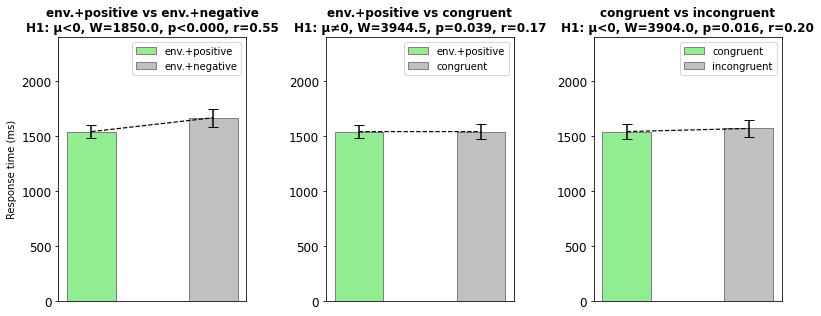

In [36]:
d = [[eco_pos.time, eco_neg.time],
     [eco_pos.time, con.time],
#    [eco_neg.time, inc.time],
     [con.time, inc.time]]

w = wilcoxon(d[0][0], d[0][1], alternative='less',)
r = cohen_r(w[1], len(d[0][0]))
t = [f'env.+positive vs env.+negative\nH1: μ<0, W={w[0]}, p<{w[1]:.3f}, r={r:.2f}']
w = wilcoxon(d[1][0], d[1][1], alternative='two-sided')
r = cohen_r(w[1], len(d[1][0]))
t += [f'env.+positive vs congruent\nH1: μ≠0, W={w[0]}, p={w[1]:.3f}, r={r:.2f}']
w = wilcoxon(d[2][0], d[2][1], alternative='less')
r = cohen_r(w[1], len(d[2][0]))
t += [f'congruent vs incongruent\nH1: μ<0, W={w[0]}, p={w[1]:.3f}, r={r:.2f}']

l=[['env.+positive', 'env.+negative'],
   ['env.+positive', 'congruent'],
#  ['env.+negative', 'incongruent'],
   ['congruent', 'incongruent']]

barWidth = 0.2
fig, axs = plt.subplots(1, len(d), figsize=(11.5, 4.5))
for i, ax in enumerate(axs.flat):
    m1 = bootstrap(d[i][0])
    m2 = bootstrap(d[i][1])
    ax.bar(0.0, m1[0], width = barWidth, color = 'lightgreen', edgecolor = 'gray', capsize=5, label=l[i][0], yerr=m1[1])
    ax.bar(0.5, m2[0], width = barWidth, color = 'silver', edgecolor = 'gray', capsize=5, label=l[i][1], yerr=m2[1])
    ax.plot((0.0, 0.5), (m1[0], m2[0]), 'k--', linewidth = 1.2)
    if i > 0:
      pass
    else:
      ax.set_ylabel('Response time (ms)')
    ax.set_xticklabels([])
    ax.legend()
    ax.set_xticks([])
    ax.set_title(t[i], fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelsize=12)
    ax.set_ylim([0, 2400])
plt.tight_layout()

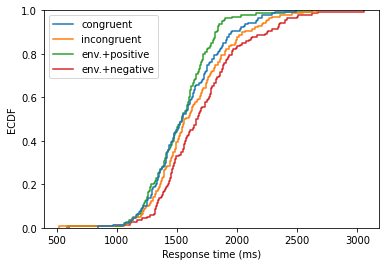

In [37]:
def plot_ecdf(data, label=''):
    fig = plt.figure()
    ax = fig.add_subplot()
    sns.ecdfplot(data = data, legend = data)
    plt.xlabel(label)
    plt.ylabel("ECDF")
    plt.show()

_d = {'congruent': con.time,
      'incongruent': inc.time,
      'env.+positive': eco_pos.time,
      'env.+negative': eco_neg.time}

plot_ecdf(_d, 'Response time (ms)')

#### Contrast analysis

For the AFP, participants will be quicker to respond when the primes are positive or associated with the environment and the target is also positive rather than negative. This can be reflected in contrast codes (-1,-1,2) X (-1, 1) vs. (-1,1,0) X (-1,1). Then, the authors could look at the simple effects by looking at the effect of the prime when the targets are positive (-1,-1, 2) X (1, 0), and when the targets are negative (-1, -1, 2) X (0, 1).

In [39]:
# https://personal.utdallas.edu/~herve/abdi-contrasts2010-pretty.pdf
# https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.t_test.html
d = data.copy()
invalid = d[d.time > 4000].id.unique()
d = d[d.id.apply(lambda x: not x in invalid)]
print(f'{len(invalid)} - dropout')
d['p_env'] = d['test'].apply(lambda x: x in eco)
d['p_pos'] = d['test'] == pos
d['p_neg'] = d['test'] == neg
d['t_pos'] = d['ctrl'] == pos
d['t_neg'] = d['ctrl'] == neg
d['t_neut'] = d['ctrl'] == neut
d = d.groupby(by=['id', 'p_env', 'p_pos', 'p_neg', 't_pos', 't_neg', 't_neut'])\
          .aggregate(np.mean).reset_index()
d = d[d['t_neut'] == False][['id', 'p_env', 'p_pos', 'p_neg', 't_pos', 't_neg', 'time']]

f = 'time ~ p_env + p_pos + p_neg + t_pos + t_neg'
# use robust linear regression https://www.statsmodels.org/stable/rlm.html
m = smf.rlm(f, d, M=sm.robust.norms.HuberT()).fit()
f_test = m.f_test([[0, 1, 1, -2, 1, -1], 
                   [0, 1, -1, 0, 1, -1]])
print(f_test)
print(f'Cohen’s d* = {cohen_d(f_test)}')
print('* Cohen’s d derived from F statistic (Fritz et al., 2012)')

71 - dropout
<F test: F=array([[4.98956417]]), p=0.007012791453211962, df_denom=836, df_num=2>
Cohen’s d* = 0.21851092783227735
* Cohen’s d derived from F statistic (Fritz et al., 2012)


In [40]:
m.t_test([[0, 1, 1, -2, 1, -1], 
          [0, 1, -1, 0, 1, -1]])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0          -134.9980     53.520     -2.522      0.012    -239.895     -30.101
c1           -90.6247     36.083     -2.512      0.012    -161.347     -19.903

In [41]:
m.f_test([0, 1, 1, -2, 1, -1])

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[6.36239893]]), p=0.011840994788163549, df_denom=836, df_num=1>

In [ ]:
m.f_test([0, 1, -1, 0, 1, -1])

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[6.30785685]]), p=0.012207891615787348, df_denom=836, df_num=1>

### AMP

In [42]:
d = data.copy()
a = d[(d.test == neg) & (d.ctrl == neg) & (d.valence > 3)].id.unique()
b = d[(d.test == pos) & (d.ctrl == pos) & (d.valence < 3)].id.unique()
invalid = {*a, *b}
print(f'{len(invalid)} - dropout')
d = d[d.id.apply(lambda x: not x in invalid)]
pos_neut = d[(d.test == pos) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #positive-neutral
neg_neut = d[(d.test == neg) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #negative-neutral
eco_neut = d[d.test.apply(lambda x: x in eco) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #eco-neutral
rec_neut = d[(d.test == rec) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sav_neut = d[(d.test == sav) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sho_neut = d[(d.test == sho) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
tra_neut = d[(d.test == tra) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
print(f'n={len(pos_neut)}')
print(f'eco valence median: {eco_neut.valence.median()}')
print(f'pos vs neg mean diff {pos_neut.valence.mean()-neg_neut.valence.mean():.2f} pts')
print(f'eco vs neg mean diff {eco_neut.valence.mean()-neg_neut.valence.mean():.2f} pts') 
print(f'eco vs pos mean diff {eco_neut.valence.mean()-pos_neut.valence.mean():.2f} pts')

43 - dropout
n=168
eco valence median: 3.125
pos vs neg mean diff 0.39 pts
eco vs neg mean diff 0.33 pts
eco vs pos mean diff -0.06 pts


In [43]:
# Normality tests
from scipy import stats
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
k, p = stats.normaltest(eco_neut.valence)
print(f"p = {p:g} ~ {p:.3f}")
k, p = stats.normaltest(pos_neut.valence)
print(f"p = {p:g} ~ {p:.3f}")
k, p = stats.normaltest(neg_neut.valence)
print(f"p = {p:g} ~ {p:.3f}")

p = 0.104995 ~ 0.105
p = 0.572761 ~ 0.573
p = 0.430807 ~ 0.431


In [44]:
cor_p = pearsonr(eco_neut.valence, eco_neut.time)
cor_s = spearmanr(eco_neut.valence, eco_neut.time)
ci = spearmanCI(cor_s[0], len(eco_neut.valence))
print(f'Correlation between valence and responce time (env.):')
print(f'Pearson r({len(eco_neut.valence)-2})={cor_p[0]:.2f} p={cor_p[1]:.3f}')
print(f'Spearman r({len(eco_neut.valence)-2})={cor_s[0]:.2f}, 95%CI [{ci[0]:.2f}–{ci[1]:.2f}], p={cor_s[1]:.3f}')

cor_p = pearsonr(pos_neut.valence, pos_neut.time)
cor_s = spearmanr(pos_neut.valence, pos_neut.time)
ci = spearmanCI(cor_s[0], len(pos_neut.valence))
print(f'Correlation between valence and responce time (pos):')
print(f'Pearson r({len(pos_neut.valence)-2})={cor_p[0]:.2f} p={cor_p[1]:.3f}')
print(f'Spearman r({len(pos_neut.valence)-2})={cor_s[0]:.2f}, 95%CI [{ci[0]:.2f}–{ci[1]:.2f}], p={cor_s[1]:.3f}')

cor_p = pearsonr(neg_neut.valence, neg_neut.time)
cor_s = spearmanr(neg_neut.valence, neg_neut.time)
ci = spearmanCI(cor_s[0], len(neg_neut.valence))
print(f'Correlation between valence and responce time (neg):')
print(f'Pearson r({len(neg_neut.valence)-2})={cor_p[0]:.2f} p={cor_p[1]:.3f}')
print(f'Spearman r({len(neg_neut.valence)-2})={cor_s[0]:.2f}, 95%CI [{ci[0]:.2f}–{ci[1]:.2f}], p={cor_s[1]:.3f}')

Correlation between valence and responce time (env.):
Pearson r(166)=0.05 p=0.508
Spearman r(166)=0.03, 95%CI [-0.12–0.18], p=0.706
Correlation between valence and responce time (pos):
Pearson r(166)=-0.06 p=0.406
Spearman r(166)=-0.08, 95%CI [-0.23–0.07], p=0.304
Correlation between valence and responce time (neg):
Pearson r(166)=0.02 p=0.817
Spearman r(166)=0.11, 95%CI [-0.05–0.25], p=0.175


In [45]:
print(f'AMP, affective valence analysis with the paired Wilcoxon signed-rank test')
t1, p1 = wilcoxon(pos_neut.valence, neg_neut.valence)
t2, p2 = wilcoxon(pos_neut.valence, neg_neut.valence, alternative='greater')
r1 = cohen_r(p1, len(pos_neut.valence))
r2 = cohen_r(p2, len(pos_neut.valence))
m1 = bootstrap(pos_neut.valence)
m2 = bootstrap(neg_neut.valence)
print(f'''
positive vs negative
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-greater: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
t1, p1 = wilcoxon(eco_neut.valence, pos_neut.valence)
t2, p2 = wilcoxon(eco_neut.valence, pos_neut.valence, alternative='less')
r1 = cohen_r(p1, len(eco_neut.valence))
r2 = cohen_r(p2, len(eco_neut.valence))
m1 = bootstrap(eco_neut.valence)
m2 = bootstrap(pos_neut.valence)
print(f'''
env. vs positive
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-less: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
t1, p1 = wilcoxon(eco_neut.valence, neg_neut.valence)
t2, p2 = wilcoxon(eco_neut.valence, neg_neut.valence, alternative='greater')
r1 = cohen_r(p1, len(eco_neut.valence))
r2 = cohen_r(p2, len(eco_neut.valence))
m1 = bootstrap(eco_neut.valence)
m2 = bootstrap(neg_neut.valence)
print(f'''
env. vs negative
Mdn1={m1[0]:.1f}, 95%CI†[{m1[0] - m1[1]:.1f}–{m1[0] + m1[1]:.1f}],
Mdn2={m2[0]:.1f}, 95%CI†[{m2[0] - m2[1]:.1f}–{m2[0] + m2[1]:.1f}],
two-sided: W={t1}, p={p1:.3f}, r‡={r1:.2f},
alternative-greater: W={t2}, p={p2:.3f}, r‡={r2:.2f}
''')
print('Note. Null hypothesis H0: the median of the differences is located at zero, μ = 0.')
print('One-sided alternative (less) hypothesis H1: the median of the differences is located on the left, μ < 0.')
print('One-sided alternative (greater) hypothesis H2: the median of the differences is located on the right, μ > 0.')
print('† Bootstrapped 95% confidence intervals for the median from 10000 resamples are reported.')
print('‡ Cohen’s r (Fritz et al., 2012; Cohen, 1988) for Wilcoxon signed-rank test is reported.')

AMP, affective valence analysis with the paired Wilcoxon signed-rank test

positive vs negative
Mdn1=3.2, 95%CI†[3.1–3.4],
Mdn2=2.8, 95%CI†[2.6–2.9],
two-sided: W=3971.5, p=0.000, r‡=0.31,
alternative-greater: W=8589.5, p=0.000, r‡=0.32


env. vs positive
Mdn1=3.1, 95%CI†[3.0–3.2],
Mdn2=3.2, 95%CI†[3.1–3.4],
two-sided: W=5250.0, p=0.155, r‡=0.11,
alternative-less: W=5250.0, p=0.077, r‡=0.14


env. vs negative
Mdn1=3.1, 95%CI†[3.0–3.2],
Mdn2=2.8, 95%CI†[2.6–2.9],
two-sided: W=3845.5, p=0.000, r‡=0.33,
alternative-greater: W=8715.5, p=0.000, r‡=0.34

Note. Null hypothesis H0: the median of the differences is located at zero, μ = 0.
One-sided alternative (less) hypothesis H1: the median of the differences is located on the left, μ < 0.
One-sided alternative (greater) hypothesis H2: the median of the differences is located on the right, μ > 0.
† Bootstrapped 95% confidence intervals for the median from 10000 resamples are reported.
‡ Cohen’s r (Fritz et al., 2012; Cohen, 1988) for Wilcoxon

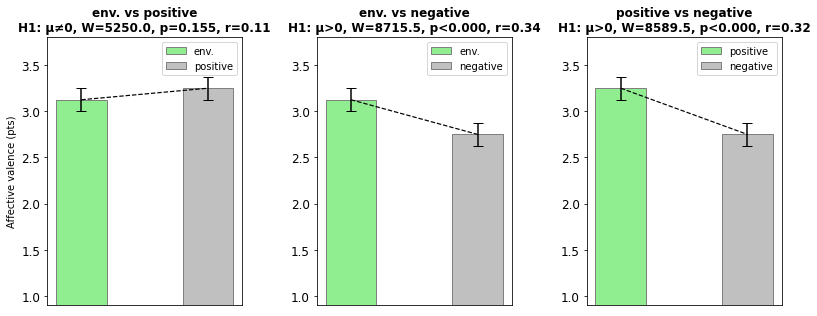

In [46]:
d = [[eco_neut.valence, pos_neut.valence],
     [eco_neut.valence, neg_neut.valence],
     [pos_neut.valence, neg_neut.valence]]

w = wilcoxon(d[0][0], d[0][1], alternative='two-sided',)
r = cohen_r(w[1], len(d[0][0]))
t = [f'env. vs positive\nH1: μ≠0, W={w[0]}, p={w[1]:.3f}, r={r:.2f}']
w = wilcoxon(d[1][0], d[1][1], alternative='greater')
r = cohen_r(w[1], len(d[1][0]))
t += [f'env. vs negative\nH1: μ>0, W={w[0]}, p<{w[1]:.3f}, r={r:.2f}']
w = wilcoxon(d[2][0], d[2][1], alternative='greater')
r = cohen_r(w[1], len(d[2][0]))
t += [f'positive vs negative\nH1: μ>0, W={w[0]}, p<{w[1]:.3f}, r={r:.2f}']

l=[['env.', 'positive'],
   ['env.', 'negative'],
   ['positive', 'negative']]

barWidth = 0.2
fig, axs = plt.subplots(1, len(d), figsize=(11.5, 4.5))
for i, ax in enumerate(axs.flat):
    m1 = bootstrap(d[i][0])
    m2 = bootstrap(d[i][1])
    ax.bar(0.0, m1[0], width = barWidth, color = 'lightgreen', edgecolor = 'gray', capsize=5, label=l[i][0], yerr=m1[1])
    ax.bar(0.5, m2[0], width = barWidth, color = 'silver', edgecolor = 'gray', capsize=5, label=l[i][1], yerr=m2[1])
    ax.plot((0.0, 0.5), (m1[0], m2[0]), 'k--', linewidth = 1.2)
    if i > 0:
      pass
    else:
      ax.set_ylabel('Affective valence (pts)')
    ax.set_xticklabels([])
    ax.legend()
    ax.set_xticks([])
    ax.set_title(t[i], fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelsize=12)
    ax.set_ylim([0.9, 3.8])
plt.tight_layout()

In [47]:
cor_p = pearsonr(eco_neut.valence, eco_neut.time)
cor_s = spearmanr(eco_neut.valence, eco_neut.time)
ci = spearmanCI(cor_s[0], len(eco_neut.valence))
print(f'Correlation between valence and responce time:')
print(f'Pearson r={cor_p[0]:.2f} p={cor_p[1]:.3f}')
print(f'Spearman r={cor_s[0]:.2f}, 95%CI [{ci[0]:.2f}–{ci[1]:.2f}], p={cor_s[1]:.3f}')

Correlation between valence and responce time:
Pearson r=0.05 p=0.508
Spearman r=0.03, 95%CI [-0.12–0.18], p=0.706


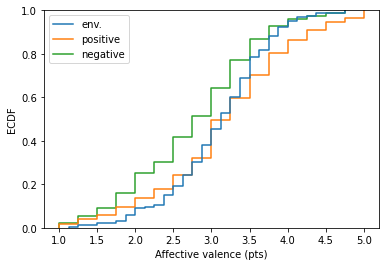

In [48]:
def plot_ecdf(data, label=''):
    fig = plt.figure()
    ax = fig.add_subplot()
    sns.ecdfplot(data = data, legend = data)
    plt.xlabel(label)
    plt.ylabel("ECDF")
    plt.show()

_d = {'env.': eco_neut.valence,
      'positive': pos_neut.valence,
      'negative': neg_neut.valence}

plot_ecdf(_d, 'Affective valence (pts)')

17 - dropout
60 - total dropout
n=151
                     Value
DoF             152.000000
DoF Baseline    177.000000
chi2            214.593304
chi2 p-value      0.000626
chi2 Baseline  1520.654984
CFI               0.953416
GFI               0.858881
AGFI              0.835671
NFI               0.858881
TLI               0.945754
RMSEA             0.052396
AIC              73.152658
BIC             187.809291
LogLik            1.423671


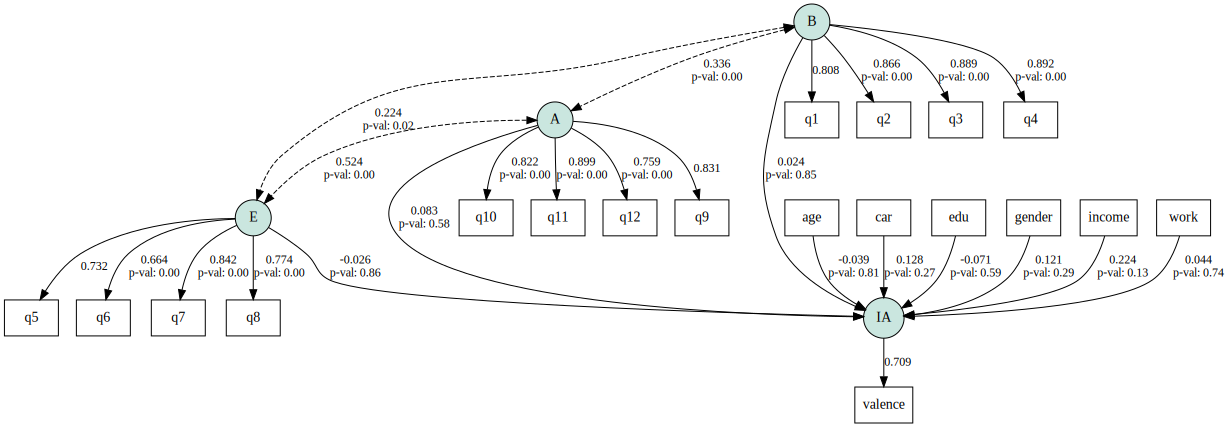

In [49]:
d = data.copy()
a = d[(d.test == neg) & (d.ctrl == neg) & (d.valence > 3)].id.unique()
b = d[(d.test == pos) & (d.ctrl == pos) & (d.valence < 3)].id.unique()
c = d[(d.q1 == 6) & (d.q2 == 5) & (d.q3 == 4) & (d.q4 == 3) & \
      (d.q5 == 3) & (d.q6 == 4) & (d.q7 == 5) & (d.q8 == 6) & \
      (d.q9 == 6) & (d.q10 == 5) & (d.q11 == 4) & (d.q12 == 3)].id.unique()
invalid = {*a, *b, *c}
print(f'{len([i for i in c if i not in {*a, *b}])} - dropout')
print(f'{len(invalid)} - total dropout')
d = d[d.id.apply(lambda x: not x in invalid)]#.dropna() #6 uncomplete
rec_v = d[(d.test == rec) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sav_v = d[(d.test == sav) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sho_v = d[(d.test == sho) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
tra_v = d[(d.test == tra) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
eco_v = d[d.test.apply(lambda x: x in eco) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #eco-neutral
print(f'n={len(eco_v)}')

random.seed(13)
np.random.seed(13)
#https://arxiv.org/pdf/2106.01140.pdf
d = eco_v.copy()
d.time = np.log(d.time)
d.age = np.log(d.age)
formula = """
B =~ q1 + q2 + q3 + q4
E =~ q5 + q6 + q7 + q8
A =~ q9 + q10 + q11 + q12
IA =~ valence
IA ~ B + E + A + gender + age + edu + car + income + work 
"""
model = sem.Model(formula)
model.fit(d, obj="MLW", solver="SLSQP") #MLW ULS GLS FIML DWLS WLS
sem.bias_correction(model, n=1000, resample_mean=True)
print(sem.calc_stats(model).T)
sem.semplot(model, "fig.pdf", plot_covs=True, std_ests=True, show=True)

17 - dropout
60 - total dropout
n=151


                      Value
DoF            5.900000e+01
DoF Baseline   7.800000e+01
chi2           1.305158e+02
chi2 p-value   2.531516e-07
chi2 Baseline  1.250855e+03
CFI            9.390242e-01
GFI            8.956587e-01
AGFI           8.620573e-01
NFI            8.956587e-01
TLI            9.193879e-01
RMSEA          8.989374e-02
AIC            6.226930e+01
BIC            1.588223e+02
LogLik         8.653489e-01


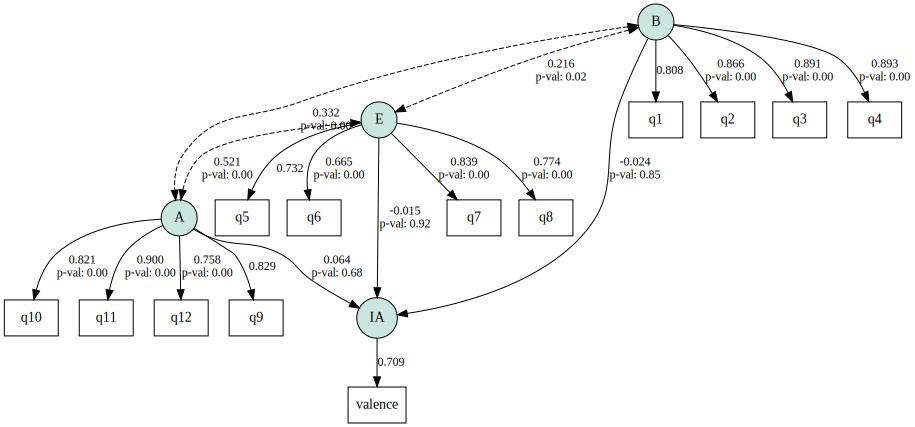

In [50]:
d = data.copy()
a = d[(d.test == neg) & (d.ctrl == neg) & (d.valence > 3)].id.unique()
b = d[(d.test == pos) & (d.ctrl == pos) & (d.valence < 3)].id.unique()
c = d[(d.q1 == 6) & (d.q2 == 5) & (d.q3 == 4) & (d.q4 == 3) & \
      (d.q5 == 3) & (d.q6 == 4) & (d.q7 == 5) & (d.q8 == 6) & \
      (d.q9 == 6) & (d.q10 == 5) & (d.q11 == 4) & (d.q12 == 3)].id.unique()
invalid = {*a, *b, *c}
print(f'{len([i for i in c if i not in {*a, *b}])} - dropout')
print(f'{len(invalid)} - total dropout')
d = d[d.id.apply(lambda x: not x in invalid)]#.dropna() #6 uncomplete
rec_v = d[(d.test == rec) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sav_v = d[(d.test == sav) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sho_v = d[(d.test == sho) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
tra_v = d[(d.test == tra) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
eco_v = d[d.test.apply(lambda x: x in eco) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #eco-neutral
print(f'n={len(eco_v)}')

random.seed(13)
np.random.seed(13)
#https://arxiv.org/pdf/2106.01140.pdf
d = eco_v.copy()
d.time = np.log(d.time)
d.age = np.log(d.age)
formula = """
B =~ q1 + q2 + q3 + q4
E =~ q5 + q6 + q7 + q8
A =~ q9 + q10 + q11 + q12
IA =~ valence
IA ~ B + E + A
"""
model = sem.Model(formula)
model.fit(d, obj="MLW", solver="SLSQP") #MLW ULS GLS FIML DWLS WLS
sem.bias_correction(model, n=1000, resample_mean=True)
print(sem.calc_stats(model).T)
sem.semplot(model, "fig.pdf", plot_covs=True, std_ests=True, show=True)

#### Contrast analysis

For the AMP, participants will have more positive evaluations of the target after exposure to positive or pro-environmental stimuli than after exposure to negative stimuli. This can be tested with contrast analyses. In concrete terms, this amounts to giving a weight to each condition, which here translates into the contrast codes (-1,-1,2) and (-1,1,0). The advantage here would be to present only one statistical test per study for each task, and thus gain statistical power. 

In [51]:
# https://personal.utdallas.edu/~herve/abdi-contrasts2010-pretty.pdf
# https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.t_test.html
d = data.copy()
a = d[(d.test == neg) & (d.ctrl == neg) & (d.valence > 3)].id.unique()
b = d[(d.test == pos) & (d.ctrl == pos) & (d.valence < 3)].id.unique()
invalid = {*a, *b}
d = d[d.id.apply(lambda x: not x in invalid)]
print(f'{len(invalid)} - dropout')
d['p_env'] = d['test'].apply(lambda x: x in eco)
d['p_pos'] = d['test'] == pos
d['p_neg'] = d['test'] == neg
d['t_pos'] = d['ctrl'] == pos
d['t_neg'] = d['ctrl'] == neg
d['t_neut'] = d['ctrl'] == neut
d = d.groupby(by=['id', 'p_env', 'p_pos', 'p_neg', 't_pos', 't_neg', 't_neut'])\
          .aggregate(np.mean).reset_index()
d = d[d['t_neut'] == True][['id', 'p_env', 'p_pos', 'p_neg', 'valence']]

f = 'valence ~ p_env + p_pos + p_neg'
# use robust linear regression https://www.statsmodels.org/stable/rlm.html
m = smf.rlm(f, d, M=sm.robust.norms.HuberT()).fit()
f_test = m.f_test([[0, 1, 1, -2], 
                   [0, 1, -1, 0]])
print(f_test)
print(f'Cohen’s d* = {cohen_d(f_test)}')
print('* Cohen’s d derived from F statistic (Fritz et al., 2012)')

43 - dropout
<F test: F=array([[11.54926135]]), p=1.2485616149248625e-05, df_denom=501, df_num=2>
Cohen’s d* = 0.4294407326305965
* Cohen’s d derived from F statistic (Fritz et al., 2012)


In [52]:
m.t_test([[0, 1, 1, -2], 
          [0, 1, -1, 0]])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.7393      0.156      4.745      0.000       0.434       1.045
c1            -0.0685      0.090     -0.761      0.447      -0.245       0.108

In [53]:
m.f_test([0, 1, 1, -2])

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[22.5191591]]), p=2.7182232080519303e-06, df_denom=501, df_num=1>

In [54]:
m.f_test([[0, -1, 1, 0]])

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.57936359]]), p=0.44691999047581976, df_denom=501, df_num=1>